In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [20]:
def generate_data(n_samples_1, n_samples_2, noise_level, seed=15, display=False):
    n_samples_1, n_samples_3 = int(n_samples_1 / 2), int(n_samples_1 / 2)
    n_samples_2, n_samples_4 = int(n_samples_2 / 2), int(n_samples_2 / 2)
    centers = [[0.0, 0.0], [0.0, 1.5], [1.5, 1.5], [1.5, 0.0]]
    clusters_std = [0.4, 0.4, 0.4, 0.4]
    X, y = make_blobs(n_samples=[n_samples_1, n_samples_2, n_samples_3, n_samples_4],
                      centers=centers,
                      cluster_std=clusters_std,
                      random_state = 15,
                      shuffle=False)
    
    # Add x1 * x2 to data
    nonlinearity = X[:, 0] * X[:, 1]
    nonlinearity = nonlinearity[:, None]
    X = np.hstack((X, nonlinearity))
    
    # Set diagnoals to be the same class
    y = y % 2
    
    # Split into train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # Create 1:9 majority:minority class imbalance for training data
    class_0_idxs = np.where(y_train == 0)[0] # Majority class
    class_1_idxs = np.where(y_train == 1)[0] # Minority class
    new_class_0_size = len(class_1_idxs) // 9
    new_class_0_idxs = np.random.choice(class_0_idxs, new_class_0_size)
    new_idxs = list(new_class_0_idxs) + list(class_1_idxs)
    X_train = X_train[new_idxs]
    y_train = y_train[new_idxs]
    
    # Randomly flip a percentage of training labels
    n = len(y_train)
    y_train = np.array([abs(1 - y_train[i]) if i in random.sample(range(n), int(noise_level * n)) else y_train[i] for i in range(n)])

    if display:
        plt.scatter(X_train[:,0], X_train[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_train])
#         plt.savefig('class_imbalance_train_5_percent_noise.png')
#         plt.scatter(X_test[:,0], X_test[:,1], c=['#516091' if y==1 else '#A9ECA2' for y in y_test])
    
    y_train = y_train.reshape(-1, 1)
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train, dtype=torch.float)
    
    y_test = y_test.reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.float)
    
    return X_train, X_test, y_train, y_test

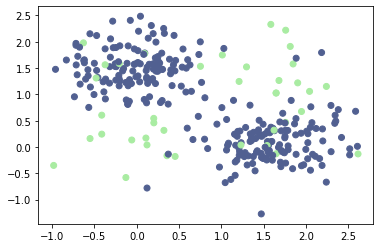

In [21]:
X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, display=True)

In [4]:
import sys
sys.path.insert(0, '/Users/william/Documents/CMU/Research/RiskSensitiveLearning/SupervisedLearning/objectives')
import cvar, human_aligned_risk, entropic_risk, trimmed_risk, mean_variance

In [5]:
input_size = 3
output_size = 2

class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        return x

epochs = 2000
learning_rate = 1e-2

In [7]:
def eval_under_objective(model, X, y, objective):
    model.eval()
    with torch.no_grad():
        output = model(X)
        loss = objective(output, y.squeeze(1).type(torch.LongTensor))
    return loss.item()

In [17]:
seeds = [i for i in range(10)]
noises = [0.2, 0.35, 0.5]
objectives = {
#     'Expected Value': nn.CrossEntropyLoss(),
#     'CVaR': cvar.CVaR(a=0.1), # We look at bottom alpha% of losses
    'Entropic Risk': entropic_risk.EntropicRisk(t=10),
    'Human-Aligned Risk': human_aligned_risk.HumanAlignedRisk(a=0.4, b=0.3),
    'Inverted CVaR': cvar.CVaR(a=0.1, inverted=True), # We look at top alpha% of losses
    'Mean-Variance': mean_variance.MeanVariance(c=0.5),
    'Trimmed Risk': trimmed_risk.TrimmedRisk(a=0.1),
}
eval_objectives = {
    'Expected Value': nn.CrossEntropyLoss(),
    'CVaR': cvar.CVaR(a=0.1), # We look at bottom alpha% of losses
    'Entropic Risk': entropic_risk.EntropicRisk(t=1),
    'Human-Aligned Risk': human_aligned_risk.HumanAlignedRisk(a=0.4, b=0.3),
    'Inverted CVaR': cvar.CVaR(a=0.1, inverted=True), # We look at top alpha% of losses
    'Mean-Variance': mean_variance.MeanVariance(c=0.5),
    'Trimmed Risk': trimmed_risk.TrimmedRisk(a=0.1),
}

metrics = {}
for objective in objectives.keys():
    metrics[objective + '_train'] = dict()
    metrics[objective + '_test'] = dict()
    for noise in noises:
        metrics[objective + '_test']['accuracy_noise=' + str(noise)] = []
        metrics[objective + '_test']['majorityaccuracy_noise=' + str(noise)] = []
        metrics[objective + '_test']['minorityaccuracy_noise=' + str(noise)] = []
        for seed in seeds:
            X_train, X_test, y_train, y_test = generate_data(2000, 400, 0.05, seed=seed)
            # Get objective
            criterion = objectives[objective]

            # Reset random seeds for comparaison.
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            model = LogisticRegression(input_size, output_size)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            # Train
            model.train()
            for epoch in range(epochs):
                # clear the gradients so they wont accumulate
                optimizer.zero_grad()

                output = model(X_train)
                loss = criterion(output, y_train.squeeze(1).type(torch.LongTensor))

                # calculate gradient
                loss.backward()

                # gradient descent
                optimizer.step()

            model.eval()
            
            for eval_objective in eval_objectives.keys():
                if eval_objective + '_noise=' + str(noise) not in metrics[objective + '_train']:
                    metrics[objective + '_train'][eval_objective + '_noise=' + str(noise)] = []
                if eval_objective + '_noise=' + str(noise) not in metrics[objective + '_test']:
                    metrics[objective + '_test'][eval_objective + '_noise=' + str(noise)] = []
                # Evaluate under training data
                metrics[objective + '_train'][eval_objective + '_noise=' + str(noise)].append(eval_under_objective(model, X_train, y_train, eval_objectives[eval_objective]))
                # Evaluate under test data
                metrics[objective + '_test'][eval_objective + '_noise=' + str(noise)].append(eval_under_objective(model, X_test, y_test, eval_objectives[eval_objective]))
                        
            # Evaluate test accuracy
            with torch.no_grad():
                output = model(X_test)
                pred = torch.argmax(F.softmax(output, dim=1), dim=1)
                overall_acc = sum(1 for p, y in zip(pred, y_test) if p == y) / len(pred)
                metrics[objective + '_test']['accuracy_noise=' + str(noise)].append(overall_acc)
                
                majority_idxs = torch.where(y_test == 0)[0]
                minority_idxs = torch.where(y_test == 1)[1]

                majority_acc = sum(1 for x, y in zip(pred[majority_idxs], y_test[majority_idxs]) if x == y) / len(pred[majority_idxs])
                minority_acc = sum(1 for x, y in zip(pred[minority_idxs], y_test[minority_idxs]) if x == y) / len(pred[minority_idxs])

                metrics[objective + '_test']['majorityaccuracy_noise=' + str(noise)].append(majority_acc)
                metrics[objective + '_test']['minorityaccuracy_noise=' + str(noise)].append(minority_acc)
                
        majority_acc = np.mean(metrics[objective + '_test']['majorityaccuracy_noise=' + str(noise)])
        minority_acc = np.mean(metrics[objective + '_test']['minorityaccuracy_noise=' + str(noise)])
        overall_acc = np.mean(metrics[objective + '_test']['accuracy_noise=' + str(noise)])
        print('Objective: {}, Noise: {}, Majority Accuracy: {}, Minority Accuracy: {}, Overall Accuracy: {}\n'.format(objective, noise, majority_acc, minority_acc, overall_acc))

Objective: Entropic Risk, Noise: 0.2, Majority Accuracy: 0.41941420014526154, Minority Accuracy: 0.4, Overall Accuracy: 0.5161111111111112

Objective: Entropic Risk, Noise: 0.35, Majority Accuracy: 0.3944563586612818, Minority Accuracy: 0.3, Overall Accuracy: 0.4956944444444444

Objective: Entropic Risk, Noise: 0.5, Majority Accuracy: 0.3944563586612818, Minority Accuracy: 0.3, Overall Accuracy: 0.4956944444444444

Objective: Human-Aligned Risk, Noise: 0.2, Majority Accuracy: 0.6121814174501824, Minority Accuracy: 0.5, Overall Accuracy: 0.6766666666666666



KeyboardInterrupt: 